In [1]:
import numpy as np
import tensorflow as tf
from adult_modified import preprocess_adult_data
from sklearn import linear_model
import classifier as cl
import utils
import time
import multiprocessing as mp
import random
import matplotlib.pyplot as plt
import scipy
plt.ioff()


seed = 1
dataset_orig_train, dataset_orig_test = preprocess_adult_data(seed = seed)

x_unprotected_train, x_protected_train = dataset_orig_train.features[:, :39], dataset_orig_train.features[:, 39:]
x_unprotected_test, x_protected_test = dataset_orig_test.features[:, :39], dataset_orig_test.features[:, 39:]
y_train, y_test = dataset_orig_train.labels.reshape((-1,)), dataset_orig_test.labels.reshape((-1,))





## Running linear regression to get sensetive directions 

protected_regression = linear_model.LinearRegression(fit_intercept = False)
protected_regression.fit(x_unprotected_train, x_protected_train)
sensetive_directions = protected_regression.coef_







unprotected_directions = utils.projection_matrix(sensetive_directions)



# Casing to tensor 
y_train, y_test = y_train.astype('int32'), y_test.astype('int32')
x_unprotected_train, x_unprotected_test = tf.cast(x_unprotected_train, dtype = tf.float32), tf.cast(x_unprotected_test, dtype = tf.float32)
y_train, y_test = tf.one_hot(y_train, 2), tf.one_hot(y_test, 2)
unprotected_directions = tf.cast(unprotected_directions, dtype = tf.float32)

init_graph = utils.ClassifierGraph(50, 2)
#graph = cl.Classifier(init_graph, x_unprotected_train, y_train, x_unprotected_test, y_test, num_steps = 10000) # use for unfair algo
graph = cl.Classifier(init_graph, tf.matmul(x_unprotected_train, unprotected_directions), \
                        y_train, tf.matmul(x_unprotected_test, unprotected_directions), y_test, num_steps = 10000) # for fair algo


def fair_transform(x):
    return tf.matmul(x, unprotected_directions)

Done step 200

Done step 400

Done step 600

Done step 800

Done step 1000

Done step 1200

Done step 1400

Done step 1600

Done step 1800

Done step 2000

Done step 2200

Done step 2400

Done step 2600

Done step 2800

Done step 3000

Done step 3200

Done step 3400

Done step 3600

Done step 3800

Done step 4000

Done step 4200

Done step 4400

Done step 4600

Done step 4800

Done step 5000

Done step 5200

Done step 5400

Done step 5600

Done step 5800

Done step 6000

Done step 6200

Done step 6400

Done step 6600

Done step 6800

Done step 7000

Done step 7200

Done step 7400

Done step 7600

Done step 7800

Done step 8000

Done step 8200

Done step 8400

Done step 8600

Done step 8800

Done step 9000

Done step 9200

Done step 9400

Done step 9600

Done step 9800

Done step 10000



In [4]:
x = x_unprotected_test[10]
y = y_test[10]

In [5]:
learning_rate = 1e-3
num_steps = 200

In [6]:
x = tf.reshape(x, (1, -1))
y = tf.reshape(y, (1, -1))
x_start = x
x_base = x + tf.cast(np.random.normal(size=(1, 39)), dtype = tf.float32)
x_fair = x
for _ in range(num_steps):
    with tf.GradientTape() as g:
        g.watch(x_base)
        prob_base = graph(fair_transform(x_base))
        prob_start = graph(fair_transform(x_start))
        perturb = x_base - x_start
        loss = (utils.kl(prob_base, prob_start)) #(utils.EntropyLoss(y, prob_base)-utils.EntropyLoss(y, prob_start))/(tf.norm(perturb)+1e-2) #(utils.kl(prob_base, prob_start))/(tf.norm(perturb)+1e-2)

    gradient = g.gradient(loss, x_base)
    x_base = x_base + learning_rate * gradient 
    print(gradient)


    
for _ in range(num_steps):
    with tf.GradientTape() as g:
        g.watch(x_fair)
        prob_fair = graph(fair_transform(x_fair))
        prob_start = graph(fair_transform(x_start))
        perturb = tf.matmul(x_fair - x_start, unprotected_directions)
        loss = (utils.EntropyLoss(y, prob_fair)-utils.EntropyLoss(y, prob_start))/(tf.norm(perturb)+1e-2)


    gradient = g.gradient(loss, x_fair)
    x_fair = x_fair + learning_rate * gradient 

18469319]], shape=(1, 39), dtype=float32)
tf.Tensor(
[[ 0.10058954  0.1387999   0.42570361  0.04525433  0.00763913  0.08076924
  -0.15815361  0.073388    0.08538191 -0.07459006 -0.06866518 -0.04360965
  -0.12366299  0.1586071   0.09556513 -0.0087867  -0.07836518 -0.1418952
  -0.03486317 -0.07394874  0.06659296 -0.03468151  0.1253477  -0.14118795
  -0.12265864 -0.06662292 -0.11330901 -0.05219748  0.01754752  0.11190993
   0.09949766  0.0802857   0.06783129  0.10349359 -0.05073905 -0.18358472
  -0.15055351 -0.05584402  0.18469447]], shape=(1, 39), dtype=float32)
tf.Tensor(
[[ 0.10059017  0.13880081  0.42570642  0.04525463  0.00763918  0.08076978
  -0.15815468  0.07338848  0.08538245 -0.07459055 -0.06866563 -0.04360994
  -0.12366376  0.15860818  0.09556575 -0.00878675 -0.07836571 -0.14189611
  -0.03486339 -0.07394923  0.0665934  -0.03468175  0.12534851 -0.1411889
  -0.12265943 -0.06662336 -0.11330975 -0.05219782  0.01754764  0.11191066
   0.09949834  0.08028619  0.06783174  0.10349426 -0.

In [38]:
x_base

<tf.Tensor: shape=(1, 39), dtype=float32, numpy=
array([[ 5.9045196e-01,  2.2294505e+00, -4.9596792e-01, -2.4303302e-01,
        -1.5185855e-01, -8.4033376e-03,  6.0655270e-02,  1.3986821e-02,
        -3.1952552e-02,  6.5672301e-02,  1.1138407e+00, -3.7464503e-02,
         7.2631828e-02, -5.4519847e-03,  8.9943063e-01, -1.0127546e-03,
         6.7519985e-02,  4.5477968e-02,  4.3982413e-02,  1.4513248e-02,
        -1.1520411e-01,  3.4432167e-03, -1.3746347e-01,  9.8083206e-02,
         9.9593014e-02,  9.8841295e-02,  8.3689302e-02,  1.1289494e-01,
         9.0553349e-01, -8.5052058e-02, -3.7674610e-02, -7.3187999e-02,
         3.6109187e-02,  9.5671946e-01,  8.4462337e-02,  1.1039787e-01,
         1.5742917e-01,  1.3579361e-01, -1.3404535e-01]], dtype=float32)>

In [39]:
x_fair

<tf.Tensor: shape=(1, 39), dtype=float32, numpy=
array([[ 5.90324581e-01,  2.22970986e+00, -4.96657193e-01,
        -2.43080437e-01, -1.51448876e-01, -2.66890181e-03,
         6.54256567e-02,  1.97240543e-02, -2.33861096e-02,
         7.28967860e-02,  1.11889112e+00, -3.11811734e-02,
         7.95261860e-02, -2.20683563e-04,  9.05993342e-01,
         7.49927387e-03,  7.66514242e-02,  5.17010652e-02,
         4.54895198e-02,  1.09578930e-02, -1.02975346e-01,
         1.13441404e-02, -1.34976402e-01,  1.05464354e-01,
         1.08782411e-01,  1.01667814e-01,  8.38380530e-02,
         1.05061732e-01,  9.07006204e-01, -7.94335678e-02,
        -3.63313034e-02, -7.12887421e-02,  4.31613289e-02,
         9.78155077e-01,  9.31082070e-02,  1.18712232e-01,
         1.66470468e-01,  1.36400178e-01, -1.38724074e-01]], dtype=float32)>

In [40]:
prob_fair = graph(fair_transform(x_fair))
prob_base = graph(fair_transform(x_base))
prob_start = graph(fair_transform(x_start))

lf_fair = utils.kl(prob_fair, prob_start)/ (tf.norm(tf.matmul(x_fair-x_start, unprotected_directions)) + 1)
lf_base = utils.kl(prob_base, prob_start)/ (tf.norm(tf.matmul(x_base-x_start, unprotected_directions)) + 1)
lb_fair = utils.kl(prob_fair, prob_start)/ (tf.norm(x_fair-x_start) + 1)
lb_base = utils.kl(prob_base, prob_start)/ (tf.norm(x_base-x_start) + 1)
lf_fair, lf_base, lb_fair, lb_base

(<tf.Tensor: shape=(), dtype=float32, numpy=0.5324614>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.52236444>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.5301608>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.52139944>)

In [41]:
tf.norm(tf.matmul(x_fair-x_start, unprotected_directions))

<tf.Tensor: shape=(), dtype=float32, numpy=0.6091626>

In [42]:
tf.norm(tf.matmul(x_base-x_start, unprotected_directions))

<tf.Tensor: shape=(), dtype=float32, numpy=0.6061239>

In [43]:
tf.norm(x_fair-x_start)

<tf.Tensor: shape=(), dtype=float32, numpy=0.61614555>

In [44]:
tf.norm(x_base-x_start)

<tf.Tensor: shape=(), dtype=float32, numpy=0.6090964>

In [45]:
utils.kl(prob_fair, prob_start)

<tf.Tensor: shape=(), dtype=float32, numpy=0.856817>

In [46]:
utils.kl(prob_base, prob_start)

<tf.Tensor: shape=(), dtype=float32, numpy=0.838982>

In [47]:
prob_base, prob_fair, prob_start, unprotected_directions

(<tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[0.82899815, 0.17100187]], dtype=float32)>,
 <tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[0.8332256, 0.1667744]], dtype=float32)>,
 <tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[0.23896435, 0.7610356 ]], dtype=float32)>,
 <tf.Tensor: shape=(39, 39), dtype=float32, numpy=
 array([[ 9.9992794e-01,  5.2056956e-05,  3.5068349e-06, ...,
          2.2246281e-03,  1.0406552e-03,  1.8804225e-03],
        [ 5.2056956e-05,  9.9991375e-01, -3.4628323e-05, ...,
         -2.6118769e-03, -4.5588077e-04,  4.8536391e-04],
        [ 3.5068349e-06, -3.4628323e-05,  9.9997866e-01, ...,
         -7.7140989e-04,  1.4491813e-04,  1.1263336e-03],
        ...,
        [ 2.2246281e-03, -2.6118769e-03, -7.7140989e-04, ...,
          9.1054815e-01, -2.6019450e-02, -1.9967807e-02],
        [ 1.0406552e-03, -4.5588077e-04,  1.4491813e-04, ...,
         -2.6019450e-02,  9.8316085e-01, -3.8405459e-02],
        [ 1.8804225e-03,  4.8536391e-04, 

In [48]:
import numpy as np
import tensorflow as tf
from adult_modified import preprocess_adult_data
from sklearn import linear_model
import classifier as cl
import utils
import time
import multiprocessing as mp
import random
import matplotlib.pyplot as plt
import scipy
plt.ioff()


seed = 1
dataset_orig_train, dataset_orig_test = preprocess_adult_data(seed = seed)

x_unprotected_train, x_protected_train = dataset_orig_train.features[:, :39], dataset_orig_train.features[:, 39:]
x_unprotected_test, x_protected_test = dataset_orig_test.features[:, :39], dataset_orig_test.features[:, 39:]
y_train, y_test = dataset_orig_train.labels.reshape((-1,)), dataset_orig_test.labels.reshape((-1,))





## Running linear regression to get sensetive directions 

protected_regression = linear_model.LinearRegression(fit_intercept = False)
protected_regression.fit(x_unprotected_train, x_protected_train)
sensetive_directions = protected_regression.coef_







unprotected_directions = utils.projection_matrix(sensetive_directions)



# Casing to tensor 
y_train, y_test = y_train.astype('int32'), y_test.astype('int32')
x_unprotected_train, x_unprotected_test = tf.cast(x_unprotected_train, dtype = tf.float32), tf.cast(x_unprotected_test, dtype = tf.float32)
y_train, y_test = tf.one_hot(y_train, 2), tf.one_hot(y_test, 2)
unprotected_directions = tf.cast(unprotected_directions, dtype = tf.float32)

init_graph = utils.ClassifierGraph(50, 2)
graph = cl.Classifier(init_graph, x_unprotected_train, y_train, x_unprotected_test, y_test, num_steps = 10000) # use for unfair algo
#graph = cl.Classifier(init_graph, tf.matmul(x_unprotected_train, unprotected_directions), \
#                        y_train, tf.matmul(x_unprotected_test, unprotected_directions), y_test, num_steps = 10000) # for fair algo


def fair_transform(x):
    return tf.matmul(x, unprotected_directions)

Done step 200

Done step 400

Done step 600

Done step 800

Done step 1000

Done step 1200

Done step 1400

Done step 1600

Done step 1800

Done step 2000

Done step 2200

Done step 2400

Done step 2600

Done step 2800

Done step 3000

Done step 3200

Done step 3400

Done step 3600

Done step 3800

Done step 4000

Done step 4200

Done step 4400

Done step 4600

Done step 4800

Done step 5000

Done step 5200

Done step 5400

Done step 5600

Done step 5800

Done step 6000

Done step 6200

Done step 6400

Done step 6600

Done step 6800

Done step 7000

Done step 7200

Done step 7400

Done step 7600

Done step 7800

Done step 8000

Done step 8200

Done step 8400

Done step 8600

Done step 8800

Done step 9000

Done step 9200

Done step 9400

Done step 9600

Done step 9800

Done step 10000



In [23]:
x = tf.reshape(x, (1, -1))
y = tf.reshape(y, (1, -1))
x_start = x
x_base = x
x_fair = x
for _ in range(num_steps):
    with tf.GradientTape() as g:
        g.watch(x_base)
        prob_base = graph((x_base))
        prob_start = graph((x_start))
        perturb = x_base - x_start
        loss = (utils.kl(prob_base, prob_start))/(tf.norm(perturb)+1)

    gradient = g.gradient(loss, x_base)
    x_base = x_base + learning_rate * gradient 
    print(gradient)

    
for _ in range(num_steps):
    with tf.GradientTape() as g:
        g.watch(x_fair)
        prob_fair = graph((x_fair))
        prob_start = graph((x_start))
        perturb = tf.matmul(x_fair - x_start, unprotected_directions)
        loss = (utils.kl(prob_fair, prob_start))/(tf.norm(perturb)+1)

    gradient = g.gradient(loss, x_fair)
    x_fair = x_fair + learning_rate * gradient 

.]], shape=(1, 39), dtype=float32)
tf.Tensor(
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]], shape=(1, 39), dtype=float32)
tf.Tensor(
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]], shape=(1, 39), dtype=float32)
tf.Tensor(
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]], shape=(1, 39), dtype=float32)
tf.Tensor(
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]], shape=(1, 39), dtype=float32)
tf.Tensor(
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]], shape=(1, 39), dtype=float32)
tf.Tensor(
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]], shape

In [24]:
x = tf.cast(1, dtype = tf.float32)

In [25]:
y = x

In [26]:
y = y+1

In [27]:
x

<tf.Tensor: shape=(), dtype=float32, numpy=1.0>

In [28]:
y

<tf.Tensor: shape=(), dtype=float32, numpy=2.0>

In [22]:
p = tf.cast([0.5, 0.5], dtype = tf.float32)
q = tf.cast([0.1, 0.9], dtype= tf.float32)

In [63]:
p *tf.math.log(p/q)

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([ 0.804719 , -0.2938933], dtype=float32)>

In [53]:
np.load('output/test_distance_ratios_1.npy')

array([2.7900934e-04, 7.6540709e-03, 1.6927719e-05, ..., 1.1539459e-04,
       4.1007996e-05, 1.0383129e-03], dtype=float32)

In [54]:
np.load('output/test_distance_ratios_1_fair.npy')

array([8.5115433e-05, 2.9718280e-03, 3.3974648e-06, ..., 3.0994415e-05,
       4.2319298e-06, 1.2785196e-04], dtype=float32)

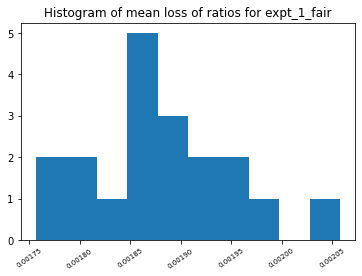

In [65]:
expt = '_1_fair'
filename = f'output/test_distance_ratios{expt}.npy'
histplot = f'output/perturbed-mean-entropy-hist{expt}.png'
qqplot = f'output/perturbed-mean-entropy-qqplot{expt}.png'


test_ratio =  np.load(filename)




def ratio_mean(n = 9045):
    index = random.sample(range(n), 1000)
    srswr_ratio=[test_ratio[i] for i in index]
    return np.mean(srswr_ratio)

ratio_means = [ratio_mean() for _ in range(5000)]
plt.hist(ratio_means)
plt.title(f'Histogram of mean loss of ratios for expt{expt}')
plt.xticks(rotation = 35, fontsize = 'x-small')
plt.show()

In [7]:
x.shape

TensorShape([1, 39])

In [1]:
import numpy as np
import tensorflow as tf
from adult_modified import preprocess_adult_data
from sklearn import linear_model
import classifier as cl
import utils
import time
import multiprocessing as mp
import random
import matplotlib.pyplot as plt
import scipy
plt.ioff()


seed = 1
dataset_orig_train, dataset_orig_test = preprocess_adult_data(seed = seed)

x_unprotected_train, x_protected_train = dataset_orig_train.features[:, :39], dataset_orig_train.features[:, 39:]
x_unprotected_test, x_protected_test = dataset_orig_test.features[:, :39], dataset_orig_test.features[:, 39:]
y_train, y_test = dataset_orig_train.labels.reshape((-1,)), dataset_orig_test.labels.reshape((-1,))





## Running linear regression to get sensetive directions 

protected_regression = linear_model.LinearRegression(fit_intercept = False)
protected_regression.fit(x_unprotected_train, x_protected_train)
sensetive_directions = protected_regression.coef_







unprotected_directions = utils.projection_matrix(sensetive_directions)



# Casing to tensor 
y_train, y_test = y_train.astype('int32'), y_test.astype('int32')
x_unprotected_train, x_unprotected_test = tf.cast(x_unprotected_train, dtype = tf.float32), tf.cast(x_unprotected_test, dtype = tf.float32)
y_train, y_test = tf.one_hot(y_train, 2), tf.one_hot(y_test, 2)
unprotected_directions = tf.cast(unprotected_directions, dtype = tf.float32)

init_graph = utils.ClassifierGraph(50, 2)
graph = cl.Classifier(init_graph, x_unprotected_train, y_train, x_unprotected_test, y_test, num_steps = 1000) # use for unfair algo
#graph = cl.Classifier(init_graph, tf.matmul(x_unprotected_train, unprotected_directions), 
#                        y_train, tf.matmul(x_unprotected_test, unprotected_directions), y_test, num_steps = 10000) # for fair algo



def distance_ratio(data_point, regularizer = 1e0, learning_rate = 1e-3, num_steps = 200):
    x, y = data_point
    x = tf.reshape(x, (1, -1))
    y = tf.reshape(y, (1, -1))
    x_start = x
    x_base = x + tf.cast(np.random.normal(size=(1, 39)), dtype = tf.float32)
    x_fair = x + tf.cast(np.random.normal(size=(1, 39)), dtype = tf.float32)
    for _ in range(num_steps):
        with tf.GradientTape() as g:
            g.watch(x_base)
            prob_base = graph(x_base)
            prob_start = graph(x_start)
            perturb = x - x_start
            loss = (utils.kl(prob_base, prob_start))/(tf.norm(perturb)+1)
        gradient = g.gradient(loss, x_base)
        x_base = x_base + learning_rate * gradient 

    
    for _ in range(num_steps):
        with tf.GradientTape() as g:
            g.watch(x_fair)
            prob_fair = graph(x_fair)
            prob_start = graph(x_start)
            perturb = tf.matmul(x - x_start, unprotected_directions)
            loss = (utils.kl(prob_fair, prob_start))/(tf.norm(perturb)+1)

        gradient = g.gradient(loss, x_fair)
        x_fair = x_fair + learning_rate * gradient 

    prob_fair = graph(x_fair)
    prob_base = graph(x_base)
    prob_start = graph(x_start)

    lf_fair = utils.kl(prob_fair, prob_start)/ (tf.norm(tf.matmul(x_fair-x_start, unprotected_directions)) + 1)
    lf_base = utils.kl(prob_base, prob_start)/ (tf.norm(tf.matmul(x_base-x_start, unprotected_directions)) + 1)
    lb_fair = utils.kl(prob_fair, prob_start)/ (tf.norm(x_fair-x_start) + 1)
    lb_base = utils.kl(prob_base, prob_start)/ (tf.norm(x_base-x_start) + 1)

    


    return (lf_fair/lb_fair-lb_base/lf_base).numpy()




cpus = mp.cpu_count()
print(f'Number of cpus : {cpus}')
start_time = time.time()
with mp.Pool(cpus) as pool:
    test_distance_ratios = pool.map(distance_ratio, zip(x_unprotected_test[:100], y_test[:100]))

Done step 200

Done step 400

Done step 600

Done step 800

Done step 1000

Number of cpus : 8


In [2]:
test_distance_ratios

[0.04687047,
 0.05860907,
 0.016896546,
 0.0424304,
 0.046212256,
 0.059898794,
 0.016908288,
 0.0426538,
 0.0465405,
 0.059900463,
 0.016173244,
 0.042657435,
 0.04664135,
 0.059538245,
 0.016817272,
 0.041697145,
 0.046664238,
 0.059935927,
 0.016739428,
 0.042364657,
 0.04633963,
 0.06005913,
 0.016875684,
 0.041928947,
 0.044982493,
 0.060162902,
 0.016397893,
 0.042036176,
 0.047617912,
 0.058369875,
 0.016578376,
 0.042359233,
 0.013582766,
 0.06503034,
 0.009570599,
 0.028912544,
 0.013533473,
 0.06531459,
 0.009200513,
 0.028774321,
 0.0131261945,
 0.06450617,
 0.009140015,
 0.029025674,
 0.013156533,
 0.065210044,
 0.009354174,
 0.028937817,
 0.013615668,
 0.06537247,
 0.00917846,
 0.028800786,
 0.013584614,
 0.06448698,
 0.009172618,
 0.028467774,
 0.013343394,
 0.064566255,
 0.009267807,
 0.029084027,
 0.013238966,
 0.064536095,
 0.009155095,
 0.029013515,
 0.050175846,
 0.013216615,
 0.047078013,
 0.019496083,
 0.050813794,
 0.013234973,
 0.046032667,
 0.019272923,
 0.04936

In [1]:
import numpy as np
import tensorflow as tf
from adult_modified import preprocess_adult_data
from sklearn import linear_model
import classifier as cl
import utils
import time
import multiprocessing as mp
import random
import matplotlib.pyplot as plt
import scipy
plt.ioff()


seed = 1
dataset_orig_train, dataset_orig_test = preprocess_adult_data(seed = seed)

x_unprotected_train, x_protected_train = dataset_orig_train.features[:, :39], dataset_orig_train.features[:, 39:]
x_unprotected_test, x_protected_test = dataset_orig_test.features[:, :39], dataset_orig_test.features[:, 39:]
y_train, y_test = dataset_orig_train.labels.reshape((-1,)), dataset_orig_test.labels.reshape((-1,))





## Running linear regression to get sensetive directions 

protected_regression = linear_model.LinearRegression(fit_intercept = False)
protected_regression.fit(x_unprotected_train, x_protected_train)
sensetive_directions = protected_regression.coef_







unprotected_directions = utils.projection_matrix(sensetive_directions)



# Casing to tensor 
y_train, y_test = y_train.astype('int32'), y_test.astype('int32')
x_unprotected_train, x_unprotected_test = tf.cast(x_unprotected_train, dtype = tf.float32), tf.cast(x_unprotected_test, dtype = tf.float32)
y_train, y_test = tf.one_hot(y_train, 2), tf.one_hot(y_test, 2)
unprotected_directions = tf.cast(unprotected_directions, dtype = tf.float32)

init_graph = utils.ClassifierGraph(50, 2)
#graph = cl.Classifier(init_graph, x_unprotected_train, y_train, x_unprotected_test, y_test, num_steps = 10000) # use for unfair algo
graph = cl.Classifier(init_graph, tf.matmul(x_unprotected_train, unprotected_directions), \
                        y_train, tf.matmul(x_unprotected_test, unprotected_directions), y_test, num_steps = 1000) # for fair algo


def fair_transform(x):
    return tf.matmul(x, unprotected_directions)

def distance_ratio(data_point, regularizer = 1e0, learning_rate = 1e-3, num_steps = 200):
    x, y = data_point
    x = tf.reshape(x, (1, -1))
    y = tf.reshape(y, (1, -1))
    x_start = x
    x_base = x + tf.cast(np.random.normal(size=(1, 39)), dtype = tf.float32)
    x_fair = x + tf.cast(np.random.normal(size=(1, 39)), dtype = tf.float32)
    for _ in range(num_steps):
        with tf.GradientTape() as g:
            g.watch(x_base)
            prob_base = graph(fair_transform(x_base))
            prob_start = graph(fair_transform(x_start))
            perturb = x - x_start
            loss = (utils.kl(prob_base, prob_start))/(tf.norm(perturb)+1)

        gradient = g.gradient(loss, x_base)
        x_base = x_base + learning_rate * gradient 

    
    for _ in range(num_steps):
        with tf.GradientTape() as g:
            g.watch(x_fair)
            prob_fair = graph(fair_transform(x_fair))
            prob_start = graph(fair_transform(x_start))
            perturb = tf.matmul(x - x_start, unprotected_directions)
            loss = (utils.kl(prob_fair, prob_start))/(tf.norm(perturb)+1)

        gradient = g.gradient(loss, x_fair)
        x_fair = x_fair + learning_rate * gradient 

    prob_fair = graph(fair_transform(x_fair))
    prob_base = graph(fair_transform(x_base))
    prob_start = graph(fair_transform(x_start))

    lf_fair = utils.kl(prob_fair, prob_start)/ (tf.norm(tf.matmul(x_fair-x_start, unprotected_directions)) + 1)
    lf_base = utils.kl(prob_base, prob_start)/ (tf.norm(tf.matmul(x_base-x_start, unprotected_directions)) + 1)
    lb_fair = utils.kl(prob_fair, prob_start)/ (tf.norm(x_fair-x_start) + 1)
    lb_base = utils.kl(prob_base, prob_start)/ (tf.norm(x_base-x_start) + 1)

    print('Done')


    return (lf_fair/lb_fair-lb_base/lf_base).numpy()




cpus = mp.cpu_count()
print(f'Number of cpus : {cpus}')
start_time = time.time()
with mp.Pool(cpus) as pool:
    test_distance_ratios = pool.map(distance_ratio, zip(x_unprotected_test[:100], y_test[:100]))

Done step 200

Done step 400

Done step 600

Done step 800

Done step 1000

Number of cpus : 8
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
